<a href="https://colab.research.google.com/github/mamun216/ML_Models/blob/master/Loan_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
The director of SZE bank identified that going through the loan applications to filter the people who can be granted loans or need to be rejected is a tedious and time-consuming process. He wants to automate it and increase his bank’s efficiency. After talking around a bit, your name pops up as one of the few data scientists who can make this possible within a limited time. Will you help the director out? 

# Objective
The idea behind this ML project is to build an ML model and web application that the bank can use to classify if a user can be granted a loan or not.

# About the Data
The dataset contains information about Loan Applicants. There are 12 independent columns and 1 dependent column. This dataset includes attributes like Loan ID, gender, if the loan applicant is married or not, the level of education, applicant’s income etc. 

# Data Description
1. Loan_ID: A unique ID assigned to every loan applicant
2. Gender: Gender of the applicant (Male, Female)
3. Married: The marital status of the applicant (Yes, No)
4. Dependents: No. of people dependent on the applicant (0,1,2,3+)
5. Education: Education level of the applicant (Graduated, Not Graduated)
6. Self_Employed: If the applicant is self-employed or not (Yes, No)
7. ApplicantIncome: The amount of income the applicant earns
8. CoapplicantIncome: The amount of income the co-applicant earns
9. LoanAmount: The amount of loan the applicant has requested for
10. Loan_Amount_Term: The  no. of days over which the loan will be paid
11. Credit_History: A record of a borrower's responsible repayment of debts (1- has all debts paid, 0- not paid)
12. Property_Area : The type of location where the applicant’s property lies (Rural, Semiurban, Urban)
13. Loan_Status: Loan granted or not (Y, N)

# Import important libraries for loading, reading and data analysis

In [193]:
import numpy as np
import pandas as pd
from statistics import mean 

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [194]:
loan_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_train.csv" )

In [195]:
loan_data.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP002305,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,1,LP001715,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1
2,2,LP002086,Female,Yes,0,Graduate,No,4333,2451.0,110.0,360.0,1.0,Urban,0
3,3,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
4,4,LP002529,Male,Yes,2,Graduate,No,6700,1750.0,230.0,300.0,1.0,Semiurban,1


In [196]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         491 non-null    int64  
 1   Loan_ID            491 non-null    object 
 2   Gender             481 non-null    object 
 3   Married            490 non-null    object 
 4   Dependents         482 non-null    object 
 5   Education          491 non-null    object 
 6   Self_Employed      462 non-null    object 
 7   ApplicantIncome    491 non-null    int64  
 8   CoapplicantIncome  491 non-null    float64
 9   LoanAmount         475 non-null    float64
 10  Loan_Amount_Term   478 non-null    float64
 11  Credit_History     448 non-null    float64
 12  Property_Area      491 non-null    object 
 13  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 53.8+ KB


## Observation: 
The above data info informes about number of observations 491, columns 14, most of the columns have null values, categorical column, numerical column, and data type  3 integer, 4 float and 7 object. 


In [197]:
loan_data.shape

(491, 14)

# Drop irrelevant columns

Here we have found Unnamed:0 column and loan_id columns are not useful for this data analysis, so we removed from the datset.

In [198]:
loan_data.drop(columns=['Unnamed: 0', 'Loan_ID'], inplace = True)

## Check the columns in dataset

In [199]:
loan_data.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

# Rename columns 
### where missing space and convert all capital letter to small letter to make easy to write code

In [200]:
loan_data = loan_data.rename(columns={'ApplicantIncome': 'applicant_income', 'CoapplicantIncome': 'co_applicant_income', 'LoanAmount': 'loan_amount'})
loan_data.rename(columns = str.lower, inplace = True)

In [201]:
loan_data.head(2)

,gender,married,dependents,education,self_employed,applicant_income,co_applicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status
0,Female,No,0,Graduate,No,4547,0.0,115.0,360.0,1.0,Semiurban,1
1,Male,Yes,3+,Not Graduate,Yes,5703,0.0,130.0,360.0,1.0,Rural,1


# Finding missing values and measures

In [202]:
loan_data.isnull().sum()

gender                 10
married                 1
dependents              9
education               0
self_employed          29
applicant_income        0
co_applicant_income     0
loan_amount            16
loan_amount_term       13
credit_history         43
property_area           0
loan_status             0
dtype: int64

In [203]:
loan_data['gender'].fillna('No Gender', inplace = True)
loan_data['married'].fillna(0, inplace = True)
loan_data['dependents'].fillna(0, inplace = True)
loan_data['self_employed'].fillna(method = 'bfill', inplace = True)
loan_data['loan_amount'].fillna(loan_data['loan_amount'].mean(), inplace = True)
loan_data['loan_amount_term'].fillna(method ='ffill', inplace = True)
loan_data['credit_history'].fillna(method = 'ffill', inplace = True)

Though gender, married, dependents column has few missing values, so I filled with that rows with 0 value and rest of categorical columns fill with forward and backward fill method and numerical column fill with mean.

In [204]:
loan_data.isnull().sum()

gender                 0
married                0
dependents             0
education              0
self_employed          0
applicant_income       0
co_applicant_income    0
loan_amount            0
loan_amount_term       0
credit_history         0
property_area          0
loan_status            0
dtype: int64

https://www.kaggle.com/ajaymanwani/loan-approval-prediction


In [205]:
loan_data.columns

Index(['gender', 'married', 'dependents', 'education', 'self_employed',
       'applicant_income', 'co_applicant_income', 'loan_amount',
       'loan_amount_term', 'credit_history', 'property_area', 'loan_status'],
      dtype='object')

In [206]:
categorical_columns = ['gender', 'married', 'dependents', 'education', 'self_employed',
                       'loan_amount_term', 'credit_history', 'property_area']
numerical_columns = ['applicant_income', 'co_applicant_income', 'loan_amount']

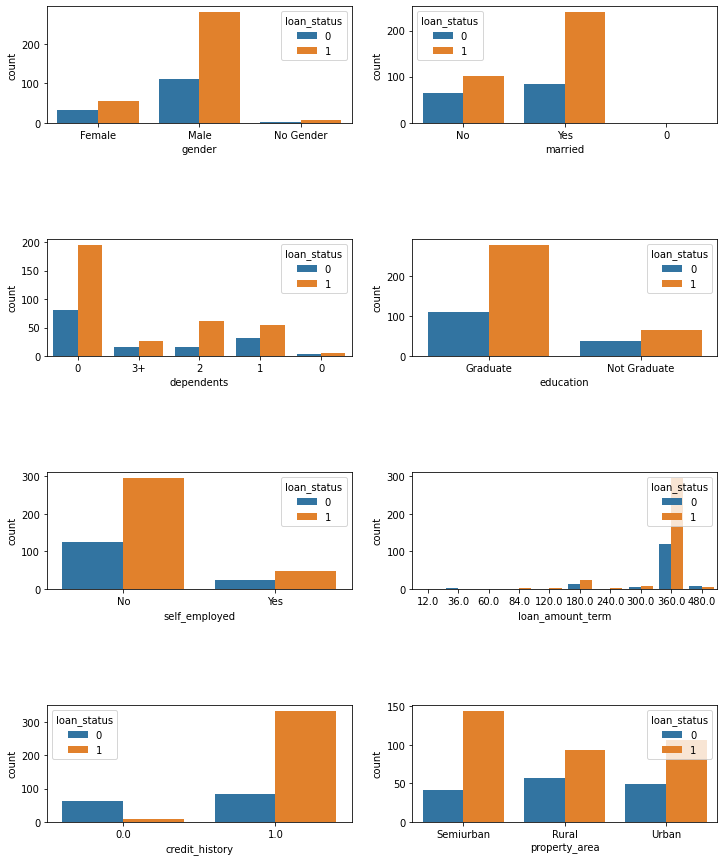

In [207]:
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=loan_data, hue='loan_status',ax=axes[row,col])

plt.subplots_adjust(hspace=1)

Plots above convey following things about the dataset:

Loan Approval Status: About 2/3rd of applicants have been granted loan.

1. Gender: There are more Men than Women (approx. 3x)
2. Martial Status: 2/3rd of the population in the dataset is Marred; Married applicants are more likely to be granted loans.
3. Dependents: Majority of the population have zero dependents and are also likely to accepted for loan.
4. Education: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval
5. Employment: 5/6th of population is not self employed. They have more chance to get loan.
6. Property Area: More applicants from Semi-urban and also likely to be granted loans.
7. Applicant with credit history are far more likely to be accepted.
8. Loan Amount Term: Majority of the loans taken are for 360 Months (30 years).


### Now, let's also analyze Numerical Columns:

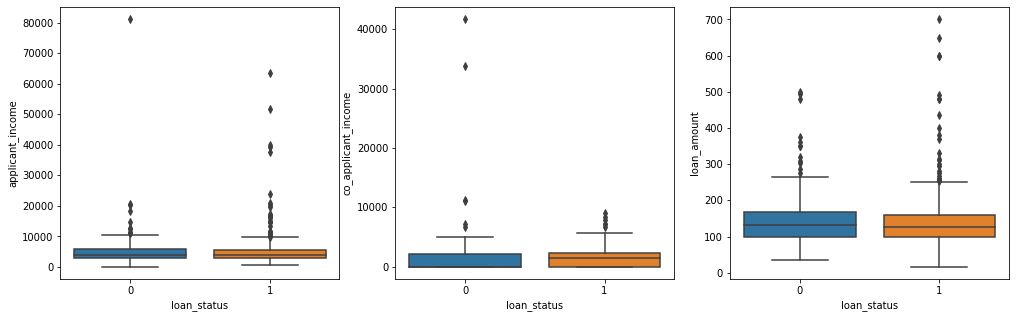

In [208]:
fig,axes = plt.subplots(1,3,figsize=(17,5))
for idx,cat_col in enumerate(numerical_columns):
    sns.boxplot(y=cat_col,data=loan_data,x='loan_status',ax=axes[idx])
plt.subplots_adjust(hspace=1)

For Numercical Columns, there is no significant relation to Loan approval status. we can see some outlier present there.

In [209]:
print(loan_data[numerical_columns].describe())

       applicant_income  co_applicant_income  loan_amount
count        491.000000           491.000000   491.000000
mean        5401.189409          1589.730998   145.014737
std         6419.427177          2919.320624    84.889687
min          150.000000             0.000000    17.000000
25%         2923.500000             0.000000   100.000000
50%         3865.000000          1229.000000   128.000000
75%         5705.500000          2251.500000   160.000000
max        81000.000000         41667.000000   700.000000


In [210]:
from scipy import stats
loan_data_outlier= loan_data[numerical_columns].copy()
z = np.abs(stats.zscore(loan_data_outlier))
print(z)

[[ 0.13319889  0.54511051  0.35393402]
 [ 0.04706314  0.54511051  0.1770539 ]
 [ 0.1665692   0.29532467  0.41289406]
 ...
 [ 1.43177495  0.54511051  0.47150655]
 [ 0.55594143 11.05742115  0.64873423]
 [ 0.40795815  0.14616543  0.41289406]]


In [211]:
threshold = 3
print(np.where(z > 3))

(array([ 18,  59,  59,  92, 137, 137, 158, 178, 194, 240, 246, 255, 261,
       287, 376, 376, 384, 384, 386, 420, 444, 489]), array([1, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 1]))


In [212]:
loan_data_outlier= loan_data_outlier[(z < 3).all(axis=1)]
loan_data_outlier.shape

(473, 3)

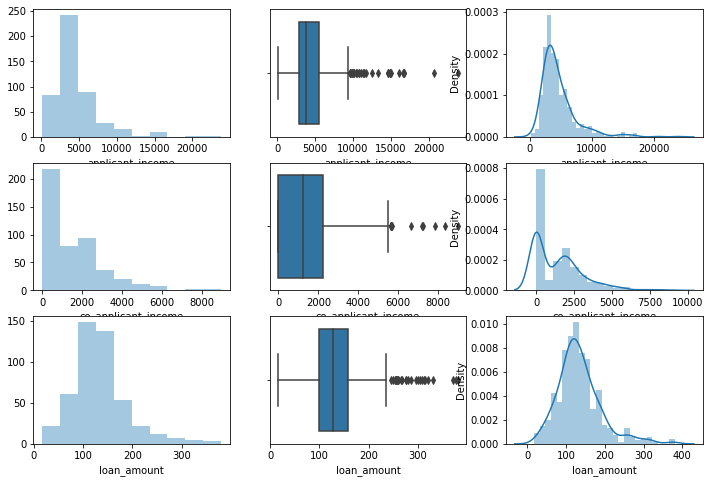

In [213]:
plt.figure(figsize=(12,8))
plt.subplot(3,3,1)
sns.distplot(loan_data_outlier['applicant_income'], kde=False, bins= 10);
plt.subplot(3,3,2)
sns.boxplot(loan_data_outlier['applicant_income']);
plt.subplot(3,3,3)
sns.distplot(loan_data_outlier['applicant_income']);

plt.subplot(3,3,4)
sns.distplot(loan_data_outlier['co_applicant_income'], kde=False, bins = 10);
plt.subplot(3,3,5)
sns.boxplot(loan_data_outlier['co_applicant_income']);
plt.subplot(3,3,6)
sns.distplot(loan_data_outlier['co_applicant_income']);

plt.subplot(3,3,7)
sns.distplot(loan_data_outlier['loan_amount'], kde=False, bins= 10);
plt.subplot(3,3,8)
sns.boxplot(loan_data_outlier['loan_amount']);
plt.subplot(3,3,9)
sns.distplot(loan_data_outlier['loan_amount']);

# Correlation withing variables

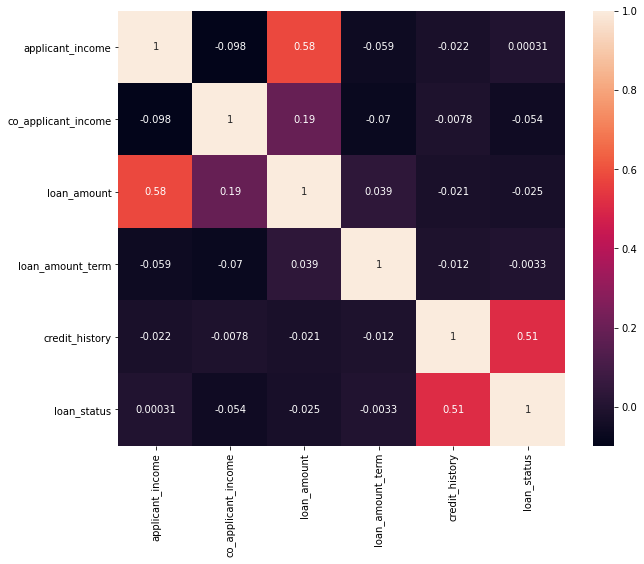

In [214]:
plt.figure(figsize = (10,8))
sns.heatmap(loan_data.corr(), annot = True); # annot = true : to display the correlation value in the graph.

Two variables are highly positively related with one relation between loan status & credit history and another relation between income with loan amount, high income person get high loan.

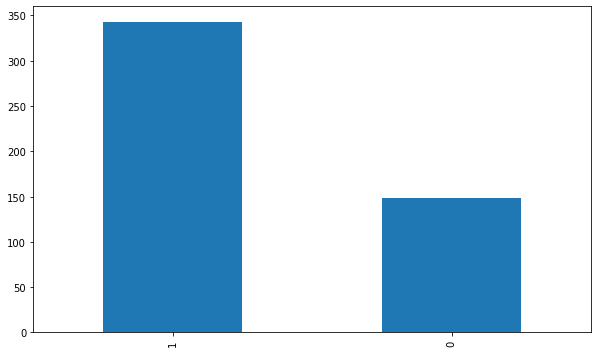

In [215]:
loan_data['loan_status'].value_counts().plot(kind= 'bar', figsize = (10,6));

# Encoding categorical features

In [216]:
loan_data_encoded = pd.get_dummies(loan_data,drop_first=True)
loan_data_encoded.head()

,applicant_income,co_applicant_income,loan_amount,loan_amount_term,credit_history,loan_status,gender_Male,gender_No Gender,married_No,married_Yes,dependents_0,dependents_1,dependents_2,dependents_3+,education_Not Graduate,self_employed_Yes,property_area_Semiurban,property_area_Urban
0,4547,0.0,115.0,360.0,1.0,1,0,0,1,0,1,0,0,0,0,0,1,0
1,5703,0.0,130.0,360.0,1.0,1,1,0,0,1,0,0,0,1,1,1,0,0
2,4333,2451.0,110.0,360.0,1.0,0,0,0,0,1,1,0,0,0,0,0,0,1
3,4695,0.0,96.0,360.0,1.0,1,1,0,0,1,1,0,0,0,1,1,0,1
4,6700,1750.0,230.0,300.0,1.0,1,1,0,0,1,0,0,1,0,0,0,1,0


In [217]:
loan_data_encoded.shape

(491, 18)

In [218]:
loan_data.shape

(491, 12)

In [219]:
loan_data_encoded['loan_status'].value_counts()

1    343
0    148
Name: loan_status, dtype: int64

# Separating Input Features and Output Features

In [221]:
# Split Features and Target Varible
X = loan_data_encoded.drop(columns='loan_status')
y = loan_data_encoded['loan_status']

# Split into train test data

In [222]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state =42);

# Model building, evaluation and performance measurement

# LogisticRegression

In [223]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
lr_pred=lr.predict(X_test)
lr_ac = f1_score(y_test, lr_pred)
print("F1 score", lr_ac)

F1 score 0.8767123287671232


# Random forest classifier

In [224]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=25, class_weight="balanced")
rfc.fit(X_train,y_train)
rf_pred = rfc.predict(X_test)
rf_ac = f1_score(y_test, rf_pred)
print("F1 score :", rf_ac)

F1 score : 0.8115942028985507


# XGBoost Classifier

In [225]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, max_depth=5, random_state=42)
xgb.fit(X_train,y_train)

# Making predictions on test data
xgb_pred = xgb.predict(X_test)

# Model performance evaluation
xgb_ac= f1_score(y_test, xgb_pred)
print('f1-score : ', xgb_ac)

f1-score :  0.8


# TEst data 

In [226]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data/loan_test.csv')
test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001116,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban
1,LP001488,Male,Yes,3+,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban
2,LP002138,Male,Yes,0,Graduate,No,2625,6250.0,187.0,360.0,1.0,Rural
3,LP002284,Male,No,0,Not Graduate,No,3902,1666.0,109.0,360.0,1.0,Rural
4,LP002328,Male,Yes,0,Not Graduate,No,6096,0.0,218.0,360.0,0.0,Rural


In [227]:
test_data.drop(columns=['Loan_ID'], inplace = True)

In [228]:
test_data = test_data.rename(columns={'ApplicantIncome': 'applicant_income', 'CoapplicantIncome': 'co_applicant_income', 'LoanAmount': 'loan_amount'})
test_data.rename(columns = str.lower, inplace = True)

In [229]:
test_data.head(2)

,gender,married,dependents,education,self_employed,applicant_income,co_applicant_income,loan_amount,loan_amount_term,credit_history,property_area
0,Male,No,0,Not Graduate,No,3748,1668.0,110.0,360.0,1.0,Semiurban
1,Male,Yes,3+,Graduate,No,4000,7750.0,290.0,360.0,1.0,Semiurban


In [230]:
test_data.isnull().sum()

gender                 3
married                2
dependents             6
education              0
self_employed          3
applicant_income       0
co_applicant_income    0
loan_amount            6
loan_amount_term       1
credit_history         7
property_area          0
dtype: int64

In [231]:
test_data['gender'].fillna('No Gender', inplace = True)
test_data['married'].fillna(0, inplace = True)
test_data['dependents'].fillna(0, inplace = True)
test_data['self_employed'].fillna(method = 'bfill', inplace = True)
test_data['loan_amount'].fillna(loan_data['loan_amount'].mean(), inplace = True)
test_data['loan_amount_term'].fillna(method ='ffill', inplace = True)
test_data['credit_history'].fillna(method = 'ffill', inplace = True)

In [232]:
test_data = test_data.dropna()
test_data.isnull().sum()

gender                 0
married                0
dependents             0
education              0
self_employed          0
applicant_income       0
co_applicant_income    0
loan_amount            0
loan_amount_term       0
credit_history         0
property_area          0
dtype: int64

In [233]:
test_data_encoded = pd.get_dummies(test_data,drop_first=True)
test_data_encoded.head()

,applicant_income,co_applicant_income,loan_amount,loan_amount_term,credit_history,gender_Male,gender_No Gender,married_No,married_Yes,dependents_0,dependents_1,dependents_2,dependents_3+,education_Not Graduate,self_employed_Yes,property_area_Semiurban,property_area_Urban
0,3748,1668.0,110.0,360.0,1.0,1,0,1,0,1,0,0,0,1,0,1,0
1,4000,7750.0,290.0,360.0,1.0,1,0,0,1,0,0,0,1,0,0,1,0
2,2625,6250.0,187.0,360.0,1.0,1,0,0,1,1,0,0,0,0,0,0,0
3,3902,1666.0,109.0,360.0,1.0,1,0,1,0,1,0,0,0,1,0,0,0
4,6096,0.0,218.0,360.0,0.0,1,0,0,1,1,0,0,0,1,0,0,0


In [234]:
test_data_encoded.shape

(123, 17)

In [235]:
predictions = lr.predict(test_data_encoded)
predictions

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Saving prediction file and sample submission

In [236]:
# To create Dataframe of predicted value with particular respective index
res = pd.DataFrame(predictions) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = test_data_encoded.index # its important for comparison.
res.columns = ["prediction"]

# To download the csv file locally
from google.colab import files
#res.to_csv('prediction_results.csv')         
#files.download('prediction_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion
After loading datasets we did cleaning, preprocessing, EDA, model building and performance testing on different model. Based on various model testing Logistic regression showed best accuracy results for loan prediction.  

